In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')

In [3]:
df = pd.read_csv('blogtext.csv', parse_dates = ['date']).sample(12000)

In [4]:
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,age,topic,sign,date,text
0,1944324,male,16,Student,Taurus,"06,November,2003",that venting is fine. It was detailed i...
1,3862883,female,15,Student,Aries,"16,July,2004",&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; The biggest...
2,3554150,male,23,indUnk,Libra,"28,June,2004","Since my last entry, I've gai..."
3,3824884,male,23,Law,Aries,"02,July,2004",urlLink Slate contributor Steven L...
4,3568300,female,27,indUnk,Aquarius,"05,July,2004",Today's Playlist: Thelonious Mon...


In [68]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')
# df['text']=df['text'].astype(str)
from gensim.parsing.preprocessing import remove_stopwords
df['tokenstr'] = df['text'].apply(lambda x: remove_stopwords(x))

#Creating the tokens, which are an important spaCy datatype.
df['tokens'] = df['tokenstr'].apply(lambda x: nlp.tokenizer(x.lower()))
spacy_stops = list([spacy.lang.en.stop_words.STOP_WORDS][0]) + ['nbsp', 'urllink', 'PRON']
#Turning the tokens to Python datatypes and cleaning, for non-spaCy work.
def clean(lst):
    lst = [token.lemma_ for token in lst if str(token.lemma_) not in spacy_stops]
    lst = [re.sub(r'[\W\d]', '', string) for string in lst]
    while '' in lst:
        lst.remove('')
    return lst
df['formatted'] = df['tokens'].map(lambda x: clean(x))
#Creating a single-string version of the cleaned texts, for tools that require it.
df['form_str'] = df['formatted'].map(lambda x: ' '.join(x))
df['formatted'].head()

0    [vent, fine, detail, information, love, life, ...
1    [nbspnbspnbspnbsp, big, similarity, movie, boo...
2    [entry, PRON, gain, highlight, heartache, bad,...
3    [slate, contributor, steven, landsburg, good, ...
4    [today, playlist, thelonious, monk, san, franc...
Name: formatted, dtype: object

In [42]:
#Make a column which is the length of the post:
df['postlength'] = df['text'].map(lambda x: len(x))
df['postlength']

0         182
1         609
2        1981
3        3922
4         551
         ... 
11995      94
11996    1377
11997      67
11998    2304
11999      65
Name: postlength, Length: 12000, dtype: int64

In [70]:
df.formatted

0        [vent, fine, detail, information, love, life, ...
1        [nbspnbspnbspnbsp, big, similarity, movie, boo...
2        [entry, PRON, gain, highlight, heartache, bad,...
3        [slate, contributor, steven, landsburg, good, ...
4        [today, playlist, thelonious, monk, san, franc...
                               ...                        
11995          [bunny, PRON, wear, shirt, anime, con, arv]
11996    [announce, officially, feel, thank, joe, peanu...
11997      [saiful, nizam, birthday, today, fall, equinox]
11998    [doubt, attack, america, sept, lynchpin, momen...
11999                         [disorder, damo, PRON, edit]
Name: formatted, Length: 12000, dtype: object

In [43]:
#Common words per label- do males use certain words more than females?
df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']
def avg_words(doclist):
    df = doclist.reset_index(drop=False)
    total_words = 0
    for doc in range(len(df)):
        total_words += len(df['text'][doc])
    return total_words / len(df)
print('Average words in female posts: {}'.format(avg_words(df_female)))
print('Average words in male posts: {}'.format(avg_words(df_male)))

Average words in female posts: 1217.3386662175817
Average words in male posts: 1098.0734081161334


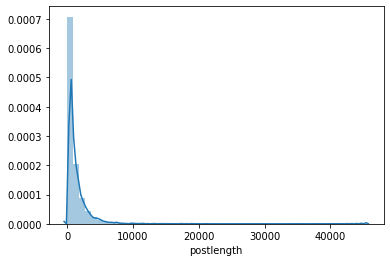

In [44]:
#Make a histogram of post lengths by gender:
sns.distplot(df_male['postlength'])

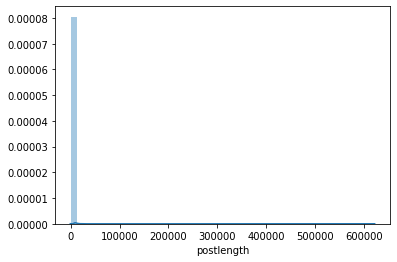

In [45]:
sns.distplot(df_female['postlength'])

In [71]:
#Get the most common words
from gensim.models import Word2Vec
w2vm_male = Word2Vec(df_male['formatted'], size=100, window=5, min_count=1, workers=8)
print('Most common male words: {}'.format(w2vm_male.wv.index2entity[:100]))
w2vm_female = Word2Vec(df_female['formatted'], size=100, window=5, min_count=1, workers=8)
print('\n \n')
print('Most common female words: {}'.format(w2vm_female.wv.index2entity[:100]))

Most common male words: ['PRON', 'good', 'like', 'think', 'time', 'know', 'day', 'people', 'thing', 'want', 'come', 'work', 'little', 'look', 'feel', 'way', 'year', 'new', 'today', 'right', 'find', 'love', 'need', 'life', 'tell', 'start', 'try', 'use', 'night', 'leave', 'friend', 'play', 'long', 'man', 'read', 'great', 'yes', 'talk', 'week', 'post', 'mean', 'home', 'guy', 'let', 'write', 'end', 'live', 'school', '_', 'old', 'late', 'lot', 'world', 'watch', 'god', 'place', 'maybe', 'sure', 'ask', 'pretty', 'oh', 'blog', 'hour', 'big', 'okay', 'actually', 'happen', 'movie', 'run', 'game', 'help', 'hope', 'change', 'bad', 'stuff', 'point', 'house', 'fun', 'head', 'fuck', 'turn', 'doe', 'meet', 'hear', 'interest', 'guess', 'away', 'stop', 's', 'girl', 'probably', 'wrong', 'word', 'nice', 'hard', 'walk', 'hand', 'cool', 'far', 'mind']

 

Most common female words: ['PRON', 'like', 'good', 'know', 'think', 'time', 'day', 'come', 'thing', 'want', 'love', 'feel', 'people', 'little', 'work', 'l

In [11]:
import gensim
doc_clean = [doc.split() for doc in df['form_str']]
#Build Bigram and Trigram models
bigram =gensim.models.Phrases(doc_clean, min_count = 5, threshold = 100)
trigram =gensim.models.Phrases(bigram[doc_clean], min_count = 5, threshold = 100)

In [13]:
#Club sentences (aka stemming)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
doc_trigram = make_trigrams(doc_clean)
#Create dictionary (word to number mapping)
dct = gensim.corpora.Dictionary(doc_trigram)
#Clean out noise
dct.filter_extremes(no_below=5, no_above=0.6666, keep_n=90000)
doc_term_matrix = [dct.doc2bow(doc) for doc in doc_trigram]

In [18]:
from gensim.models.tfidfmodel import TfidfModel
#Create tf-idf vectors
tfidf = TfidfModel(doc_term_matrix)
vectors = tfidf[doc_term_matrix]
from gensim.models.nmf import Nmf
nmf_model = Nmf(vectors, id2word = dct, num_topics=6, kappa=0.08, eval_every=500, normalize=True, passes=10, random_state=42)

print("Here's what the topics are: ")
nmf_model.print_topics()

Here's what the topics are: 


[(0,
  '0.005*"PRON" + 0.004*"that" + 0.004*"he" + 0.004*"my" + 0.004*"not" + 0.004*"it" + 0.004*"do" + 0.004*"you" + 0.004*"we" + 0.004*"me"'),
 (1,
  '0.008*"urllink" + 0.005*"you" + 0.005*"PRON" + 0.004*"my" + 0.004*"that" + 0.004*"me" + 0.004*"not" + 0.004*"it" + 0.003*"he" + 0.003*"do"'),
 (2,
  '0.005*"PRON" + 0.004*"you" + 0.004*"my" + 0.004*"urllink" + 0.004*"that" + 0.004*"it" + 0.004*"go" + 0.003*"not" + 0.003*"do" + 0.003*"he"'),
 (3,
  '0.006*"urllink" + 0.005*"PRON" + 0.004*"you" + 0.004*"that" + 0.004*"not" + 0.004*"my" + 0.003*"it" + 0.003*"do" + 0.003*"in" + 0.003*"me"'),
 (4,
  '0.005*"PRON" + 0.005*"you" + 0.004*"my" + 0.004*"that" + 0.004*"it" + 0.004*"do" + 0.004*"not" + 0.004*"we" + 0.004*"me" + 0.004*"so"'),
 (5,
  '0.007*"urllink" + 0.004*"PRON" + 0.004*"my" + 0.004*"you" + 0.004*"we" + 0.004*"that" + 0.004*"it" + 0.003*"do" + 0.003*"not" + 0.003*"in"')]

In [60]:
[spacy.lang.en.stop_words.STOP_WORDS][0]

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [67]:
from gensim.parsing.preprocessing import remove_stopwords
df['tokenstr'] = df['text'].apply(lambda x: remove_stopwords(x))

In [72]:
df['formatted']

0        [vent, fine, detail, information, love, life, ...
1        [nbspnbspnbspnbsp, big, similarity, movie, boo...
2        [entry, PRON, gain, highlight, heartache, bad,...
3        [slate, contributor, steven, landsburg, good, ...
4        [today, playlist, thelonious, monk, san, franc...
                               ...                        
11995          [bunny, PRON, wear, shirt, anime, con, arv]
11996    [announce, officially, feel, thank, joe, peanu...
11997      [saiful, nizam, birthday, today, fall, equinox]
11998    [doubt, attack, america, sept, lynchpin, momen...
11999                         [disorder, damo, PRON, edit]
Name: formatted, Length: 12000, dtype: object